In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_probability as tfp
from scipy.interpolate import RectBivariateSpline
import numpy as np
import matplotlib.pyplot as plt
import corner
import importlib
import logging
from tensorflow import keras
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

importlib.reload(logging)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(gpus[1],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


In [3]:
gaussian_number = 10
latent_dim = 10

In [57]:
model_name = 'test/5'
path = './CVAE/{}/'.format(model_name)
encoder1 = load_model(path + "encoder_1.h5", compile=False)
encoder2 = load_model(path + "encoder_2.h5", compile=False)
decoder = load_model(path + "decoder.h5", compile=False)

In [58]:
data = np.load('../../Data/best_fit_spectrum_DUNE.npz')
data_all = np.column_stack([data['ve_dune_poisson'][:,:36], data['vu_dune_poisson'][:,:36],
                            data['vebar_dune_poisson'][:,:36], data['vubar_dune_poisson'][:,:36]])
true_theta23 = data['theta23_true']
true_delta = data['delta_true']
fit_theta23 = data['theta23_fit']
fit_delta = data['delta_fit']

In [67]:
n = 6
data_poisson_array = data_all[n:n+1]/1000

mean, log_var, weight = encoder2.predict(data_poisson_array)

mean = tf.reshape(mean, (-1, gaussian_number, latent_dim))
log_var = tf.reshape(log_var, (-1, gaussian_number, latent_dim))
weight = tf.reshape(weight, (-1, gaussian_number))

SMALL_CONSTANT = 1e-12
temp_var = SMALL_CONSTANT + tf.exp(log_var)
test_sampling = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=mean,
              scale_diag=tf.sqrt(temp_var)))

sample_amount= 10000
sample_times = 10
prediction = []
for i in range(sample_times):
    Z3 = np.reshape(test_sampling.sample(sample_shape=(sample_amount)), (sample_amount, latent_dim))
    reconstruction_mean, reconstruction_var = decoder.predict([Z3, np.array(([data_poisson_array[0]]*sample_amount))])
    temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
    reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                            loc=reconstruction_mean,
                            scale_diag=temp_var)
    prediction.extend(reconstruction_parameter.sample().numpy())

prediction = np.array(prediction)

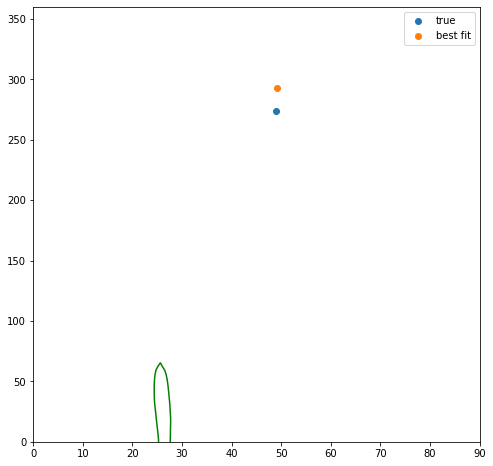

In [70]:
fig = plt.figure(figsize=(8,8))
r1 = corner.hist2d(reconstruction_mean[:, 1]*180/np.pi, reconstruction_mean[:, 2]*180/np.pi,
                    levels=(0.68,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='green',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
                    range=[[0,90], [0, 360]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    bins = [100, 100],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )
plt.scatter(true_theta23[n]*180/np.pi, true_delta[n], label='true')
plt.scatter(fit_theta23[n]*180/np.pi, fit_delta[n], label='best fit')
plt.legend()
plt.show()